# Identifying voting pattern of U.S. senators for prediction and party affiliation identification

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [9]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pickle

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Style settings

In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

party_colormap = {'R':'red', 'D': 'dodgerblue', 'I':'limegreen'}

## Load processed data

In [59]:
np.random.seed(2018)

# Load a restricted set of votes
# This set contains ony the ones most easily interpretable for a person unfamiliar with american political matters
votes_restricted = pd.read_pickle("data/processed/processed_votes_1.pickle").dropna(0)
votes_restricted, _= split_dataframe(1, votes_restricted)
print("\n\n\nThe 1st vote dataframe is a " + str(votes_restricted.shape) + " table with senators as rows and vote positions as columns.")
display(votes_restricted.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
print("\n\n\nBill descriptions is a " + str(votes_restricted.shape) + " table with senators as rows and vote positions as columns.")
display(bill_descriptions.head(3))

# Load full set of votes, including motions
votes_full = pd.read_pickle("data/processed/processed_votes_2.pickle").dropna(0)
print("\n\n\nThe 2nd vote dataframe is a " + str(votes_full.shape) + " table with roll call ID as rows and description as columns.")
display(votes_full.head(3))

# Loads the selected senators details
senators = pd.read_pickle("data/processed/processed_senators.pickle")
senators = senators.loc[senators.index.intersection(votes_full.index)]
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

#Load labels
senators_party = senators['party']
colorcode = np.vectorize({'R':'red','D':'dodgerblue','I':'limegreen'}.get)(senators_party)




The 1st vote dataframe is a (96, 23) table with senators as rows and vote positions as columns.


id,hr2-115-143-2,s722-115-147-1,sres584-115-162-2,hr1865-115-60-2,hr5515-115-128-2,s84-115-27-1,hr3364-115-175-1,hr2430-115-187-1,s2155-115-54-2,hconres71-115-245-1,...,sconres3-115-26-1,hr6157-115-193-2,sres176-115-138-1,s89-115-102-1,s2554-115-209-2,hr6147-115-180-2,treatydoc.114-12-115-98-1,hr5895-115-139-2,hr1-115-303-1,hr2810-115-199-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0





Bill descriptions is a (96, 23) table with senators as rows and vote positions as columns.


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The 2nd vote dataframe is a (96, 109) table with roll call ID as rows and description as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hconres71-115-245-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,...,sconres3-115-26-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1,sres176-115-138-1,sres584-115-162-2,treatydoc.114-12-115-98-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0





The senators dataframe is a (96, 5) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,votes_with_party_pct,name
member_id,,,,,
A000360,R,Lamar,Alexander,96.91,Lamar Alexander
B000575,R,Roy,Blunt,98.12,Roy Blunt
B000944,D,Sherrod,Brown,93.36,Sherrod Brown


## Building the similarity graph

In our graph, nodes represent senators and edges between senators indicate how similar they tend to vote on roll calls made on the senate floor. We have 96 senators for which we have a full congress worth of data and more than 100 different roll calls.

In [159]:
def build_graph(df, edge_limit=0.25, neighbor_limit=20):
    '''
    Builds the adjacency matrix by computing the similarities between senators.
    This implementation can be used to feed various features matrices and apply a different distance function and
    sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features
    '''
    features = df.values
    sparsification_function = lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, edge_limit), neighbor_limit)
    adjacency = get_adjacency_multidistance(features, cosine_similarity, lambda x:x, sparsification_function)

    G= graphs.Graph(adjacency)
    G.compute_differential_operator()
    G.compute_fourier_basis()
    G.compute_laplacian()
    
    return adjacency,G

adjacency_restricted, G_restricted = build_graph(votes_restricted)
adjacency_full,G_full = build_graph(votes_full)

### Basic statistics about the graph

Clustering coefficient: 0.6431150038686803
Diameter: 6


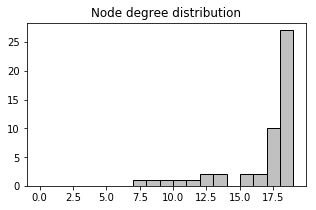

None


In [160]:
print(print_graph_specs(adjacency_full))

### The graph itself

Text(0.5,1,'Similarity graph')

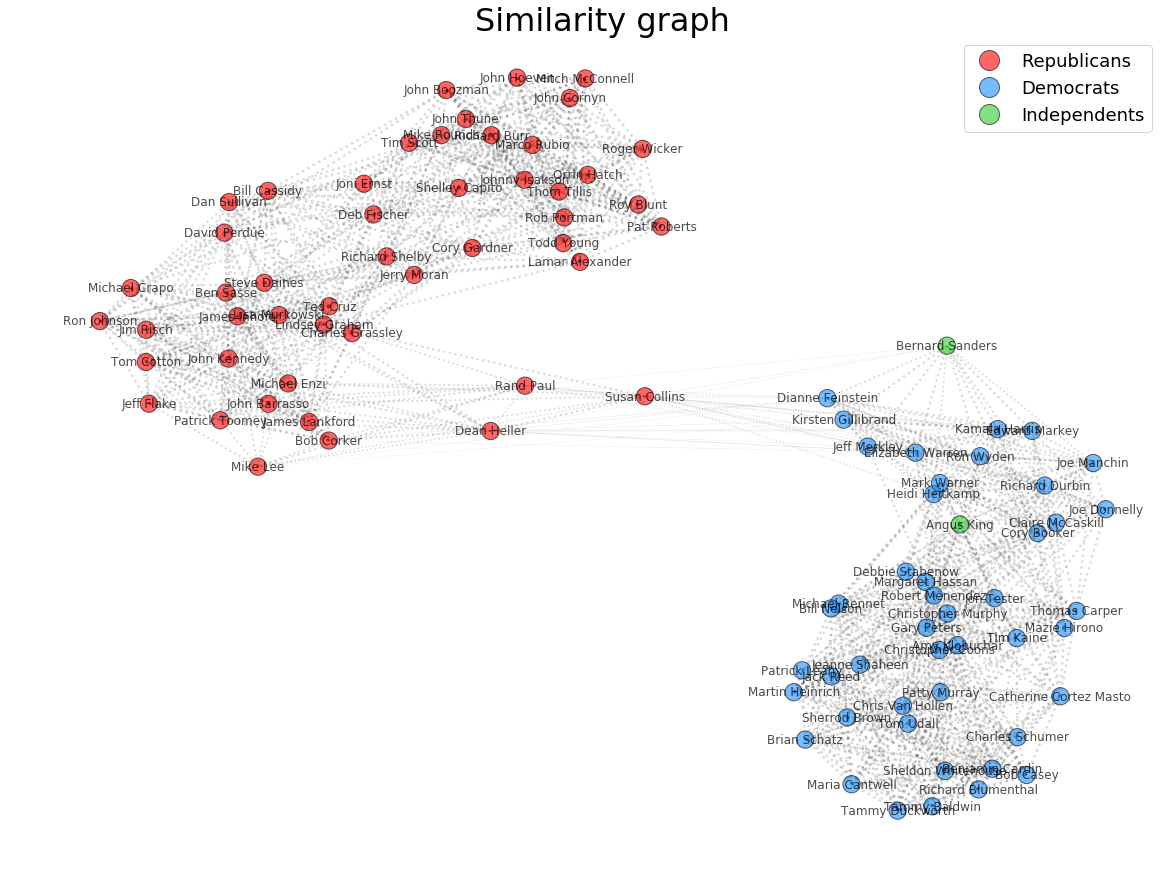

In [29]:
plot_signal(G_full.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], scale=[0,1])
r = mlines.Line2D([], [], color='red', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Republicans")
d = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black',  alpha=0.6,markersize=20, label="Democrats")
i = mlines.Line2D([], [], color='limegreen', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Independents")

plt.legend(handles=[r,d,i], prop={'size':18})
plt.savefig("similarity_graph.png")
plt.title('Similarity graph', fontsize=32)

## Political affiliation identification

Our first research question is to find whether we can use a similarity graph to identify the senators which are the closest to our own political opinions and if so, where do our opinions lie in the political continuum ? To do so, we need to collect a few vote samples where we indicate how we would have voted if we were to be a senator.

However, giving our opinion of every vote cast in the senate would be highly impractical. Therefore, we need to chose carefully the votes which will convey the highest information on our political stance.

To this end, we build a similarity graph where nodes correspond to roll calls and features to senators. This will hopefully help us distinguish subjects based on their "electoral basis". We finish by selecting the best representative among each category of vote.

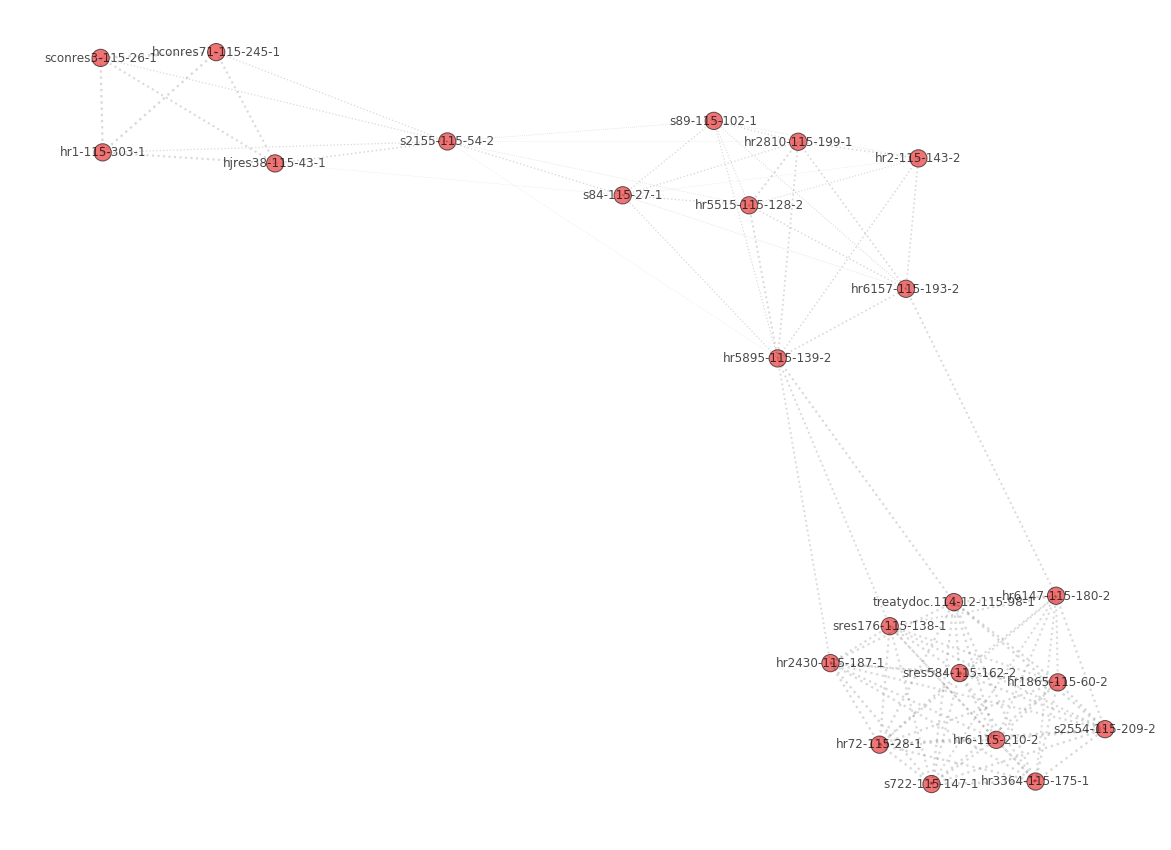

In [45]:
bill_cluster_count = 3

# Build adjacency matrix but this time where nodes are bills and features senators that voted for them
sparsification_functions = lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg,10),0.7)

# build the graph object
G_bills = graphs.Graph(
    get_adjacency_matrix(votes_restricted.T.values, cosine_similarity, lambda x:x, sparsification_functions)
)

G_bills.compute_laplacian()
G_bills.compute_fourier_basis()

plot_signal(
    G_bills.W.todense(),
    np.array([1]*votes_restricted.shape[1]),
    labels = votes_restricted.columns)

In [50]:
embedding_dimension = 2
embedding = G_bills.U[:,1:1+embedding_dimension]

clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    dist = np.linalg.norm(embedding - centers[j],axis=1)
    vote_repr[j] = np.argmin(dist)
            
vote_repr

array([10., 17.,  4.])

### Selected bills

============== INFORMATION REGARDING hjres38-115-43-1 ============== 

Roll call: 43
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00043

RELATED BILL INFORMATION

Bill title: Disapproving the rule submitted by the Department of the Interior known as the Stream Protection Rule.

Bill url:  https://www.govtrack.us/congress/bills/115/hjres38

Short description: (This measure has not been amended since it was introduced. The summary of that version is repeated here.) This joint resolution nullifies the Stream Protection Rule finalized by the Department of the Interior's Office of Surface Mining Reclamation and Enforcement on December 20, 2016. The rule addresses the impacts of surface coal mining operations on surface water, groundwater, and the productivity of mining operation sites.




============== INFORMATION REGARDING s2554-115-209-2 ============== 

Roll call: 209
Session: 2

https://www.senate.gov/legislative

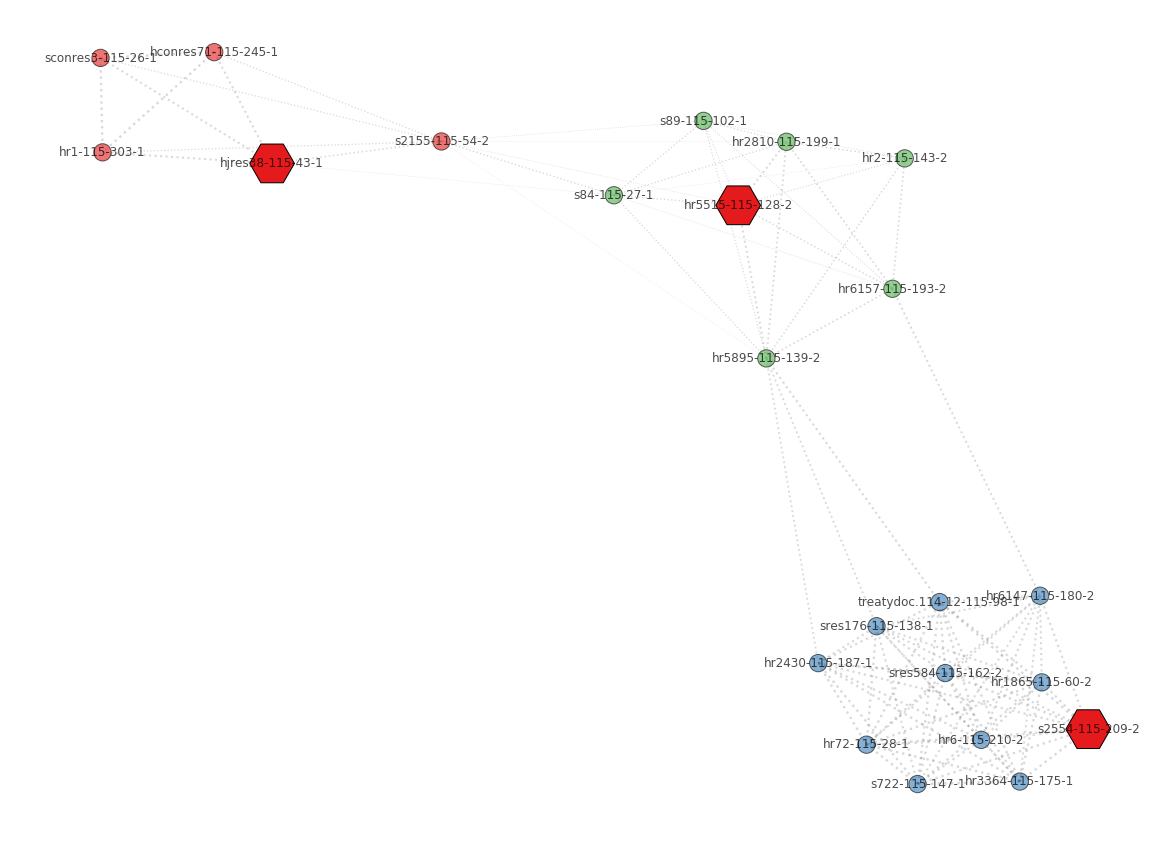

In [55]:
def print_selected_votes(votes_list,best_bills_idxs):
    """Pretty print a list of selected votes descriptions"""
    selected_votes_unique_ids = votes_list.iloc[:, best_bills_idxs].columns.values
    for v in selected_votes_unique_ids:
        print_info(v)
    bills = [x.split('-')[0] for x in selected_votes_unique_ids]
    return set(bills)

vote_selection = vote_repr.astype(int)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_restricted.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))


print_selected_votes(votes_restricted, vote_selection)
plt.savefig("bill_selection.png", bbox_inches="tight")

## Where do we stand on the graph ? 
In this section, we use the votes and similarity graphs built above to model our political orientation.The widget below shows the senators that are likely to have similar political opinion, it also measure our position in the political continuum (liberal <-> conservative).

The picked votes are:

1. **Title 1** description 1
2. **Title 2** description 2
3. **Title 3** description 3

Suppose I vote as follows:

1. Yes
2. Yes
3. No

My restricted feature vector becomes $v = [-1,-1,1]$. Computing the similarity of this vector with the other senators results in the following embedding:

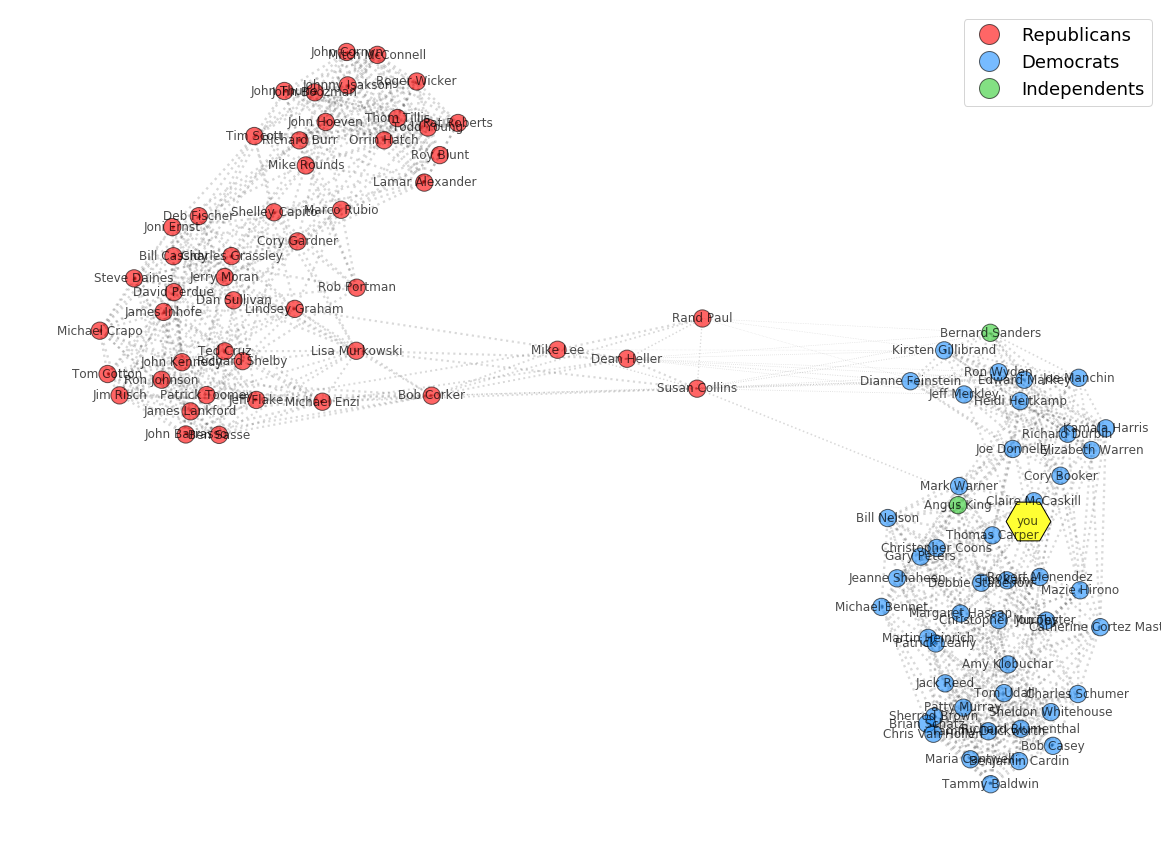

In [90]:
v = [-1,-1,1]

def compute_similarity(senator_votes,your_votes):
    """Compute the cosine similarity between your_votes and other senators votes"""
    return cosine_similarity(senator_votes, your_votes)

## Get the selected votes indices in the full feature matrix
seed_votes_idxs = [np.nonzero(votes_full.columns == votes_restricted.columns[x])[0][0] for x in vote_selection]
other_senators_vote = votes_full.values[:,seed_votes_idxs]

# Compute similarity on the restricted set of features
similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote, v)
similarity_vector[np.isnan(similarity_vector)] = 0
similarity_vector =sparsify_with_limit(similarity_vector,0.51)

# Build the new adjacency matrix
n = len(adjacency_full)
new_columns = np.append(similarity_vector, 0)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency_full
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns
new_adjacency = sparsify_with_max_neighbors(new_adjacency,15)

G_extended = graphs.Graph(new_adjacency)
G_extended.compute_fourier_basis()
G_extended.compute_laplacian()
G_extended.compute_differential_operator()

plot_signal(new_adjacency, senators['party'].map(party_colormap), labels=np.append(senators['name'].values, ['you']), scale=[0,1], highlight_node=[n], k=3.5)
plt.legend(handles=[r,d,i], prop={'size':18})

### Putting some faces to the nodes

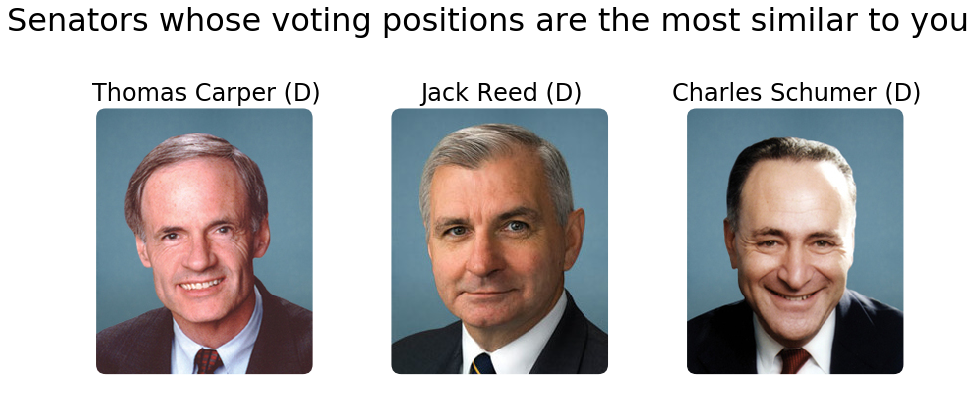

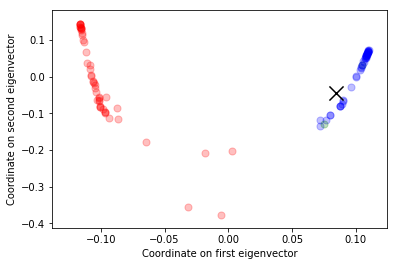

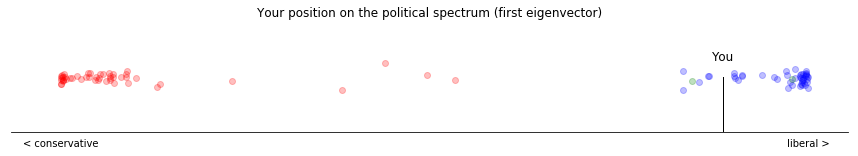

In [91]:
top_similar = similarity_vector.argsort()[-3:][::-1]
similar_senators = senators.iloc[top_similar]
show_portraits(similar_senators)    


colors = {0:'red',1:'blue',2:'green', 3:'orange'}
show_2D_embedding(G_extended.U[:,1:3], senators_party)

show_political_spectrum(G_extended.U[:,1:3], n, colors, senators_party)

## Vote predictions using Transductive learning
We use below the new similarity graph which contains your voting positions in order to predict your voting outcome on new subjects using transductive learning

In [99]:
def predict_your_votes(G, positions):
    
    # Build a subgraph from your direct neighbors
    adj = G_extended.W.todense()
    neighbors_indices = np.nonzero(adj[-1])[1]
    subgraph_indices = np.append(neighbors_indices, [len(adj)-1])
    subG = G.subgraph(subgraph_indices)
    subG.compute_differential_operator()
    
    bill_votes = np.append(positions, 0)[subgraph_indices]
    
    print(bill_votes)
    
    # Create a mask where all the neighbors are measured
    measure_mask = np.append(np.ones(len(bill_votes)-1), 0)    
    
    labels_bin = get_thresholded_values(bill_votes,0)
    sol, sol_binarized = reconstruct_signal(subG, measure_mask, labels_bin)    
    print("On vote x you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")


print_info_short(votes_full.columns[2])
predict_your_votes(G_extended, votes_full.iloc[:,2])

============== INFORMATION REGARDING hconres71-115-231-1 ============== 
Bill title: Establishing the congressional budget for the United States Government for fiscal year 2018 and setting forth the appropriate budgetary levels for fiscal years 2019 through 2027.

Bill url:  https://www.govtrack.us/congress/bills/115/hconres71


[ 1. -1.  1.  1.  0.]
On vote x you would have voted 1.0 (0.9766728855997084)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters. In this part we would like to show that we can accurately predict the outcome of a votes (passed/rejected) by only looking at the swing senators voting positions. For this purpose,we use the full feature matrix defined in the feature engineering notebook. The latter contains all the votes on bills, resolution and motions passage. We divide the collected votes into a training and test set using a 80:20 split.

(96, 22)
(96, 87)


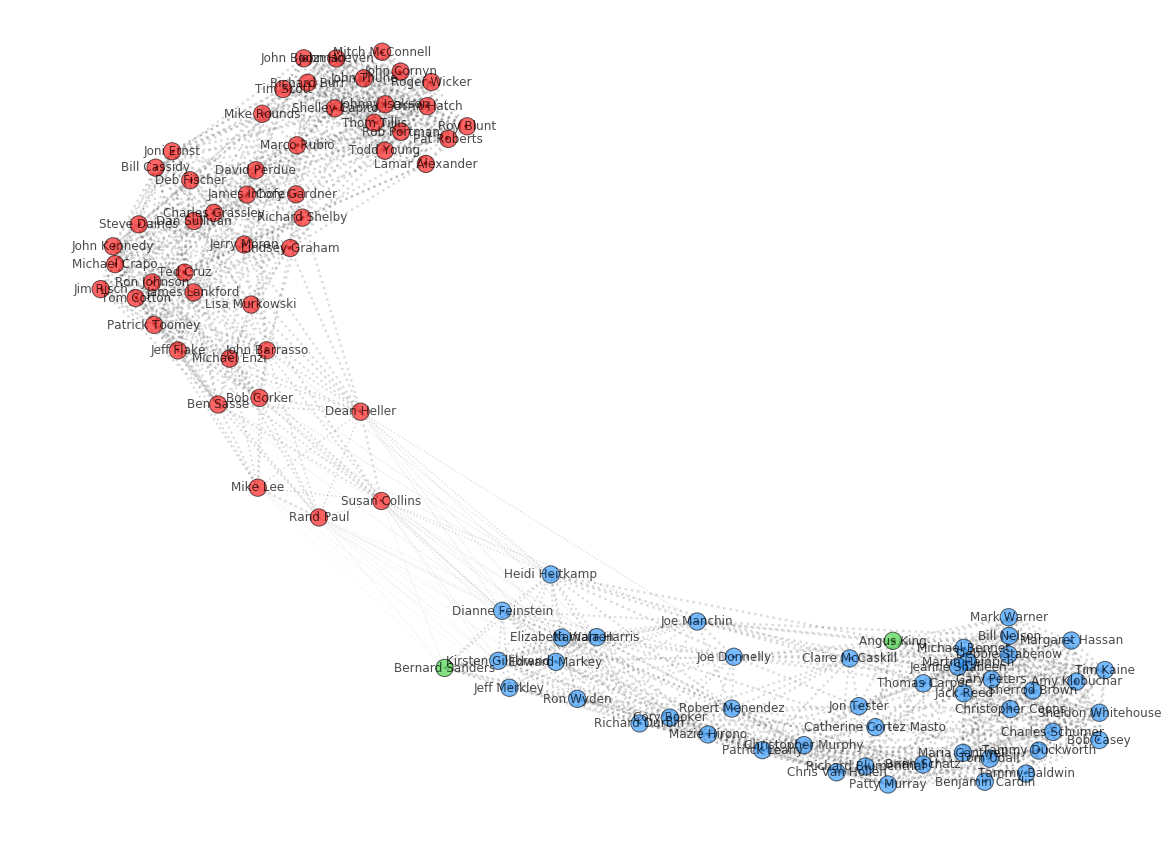

In [194]:
votes_train, votes_test = split_dataframe(0.8, votes_full)

print(votes_test.shape)
print(votes_train.shape)

adjacency_pred , G_pred = build_graph(votes_train, 0.25, 20)

plot_signal(G_pred.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], k=3.5)

We identify swing senators by defining a score which measure how closely is a senator related to senators from another political party.This done using the following formula
$$Score_i = \frac{\Sigma_{j \in A_i}W_{ij}}{\Sigma_{j=1}^n W_{ij}}$$
where W is the similarity graph adjacency matrix and $A_i$ is the set of senators which are not in the same party of senator i.

The swing senators are:

In [195]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    """
    Compute the swing score for every senator
    
    Parameters
    ----------
    adjacency : ndarray
        similarity graph adjacency matrix
    labels : array
        Senators political affiliation (Republican,Democrat,Independant)
        
    Returns
    -------
    numpy.array
    The swing score for every senator
        
    """
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  

def get_swing_senators(G,senators_party,threshold=0.0):
    ''' return the list of selected swing senators '''
    parties = senators_party.copy()
    parties[parties == 'I'] = 'D'
    swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > threshold)[0]
    non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= threshold)[0]
    return swing_senators,non_swing_senators

swing_senators, non_swing_senators = get_swing_senators(G_pred,senators_party,threshold=0.05)
print(senators['name'].iloc[swing_senators])

member_id
C001035         Susan Collins
C001071            Bob Corker
F000062      Dianne Feinstein
G000555    Kirsten Gillibrand
H001041           Dean Heller
H001069        Heidi Heitkamp
H001075         Kamala Harris
L000577              Mike Lee
M000133         Edward Markey
M001176          Jeff Merkley
M001183           Joe Manchin
P000603             Rand Paul
S000033       Bernard Sanders
S001197             Ben Sasse
W000817      Elizabeth Warren
Name: name, dtype: object


### Predicting the outcome on unseen votes
We now perform transductive learning by using the swing senators as the measured nodes and the rest as what needs to be interpolated

In [196]:
 a = predict_and_compare(G_pred, votes_test, swing_senators)

True: {-1: 10, 1: 86} Pred: {-1: 1, 1: 95} Correct: True
True: {-1: 45, 0: 1, 1: 50} Pred: {-1: 47, 0: 1, 1: 48} Correct: True
True: {-1: 46, 0: 1, 1: 49} Pred: {-1: 46, 0: 1, 1: 49} Correct: True
True: {-1: 11, 0: 2, 1: 83} Pred: {-1: 47, 1: 49} Correct: True
True: {-1: 49, 1: 47} Pred: {-1: 49, 1: 47} Correct: True
True: {-1: 2, 1: 94} Pred: {-1: 2, 1: 94} Correct: True
True: {-1: 5, 0: 8, 1: 83} Pred: {-1: 5, 1: 91} Correct: True
True: {0: 10, 1: 86} Pred: {0: 1, 1: 95} Correct: True
True: {-1: 48, 0: 1, 1: 47} Pred: {-1: 49, 1: 47} Correct: True
True: {-1: 48, 0: 6, 1: 42} Pred: {-1: 49, 0: 2, 1: 45} Correct: True
True: {-1: 47, 0: 1, 1: 48} Pred: {-1: 47, 0: 1, 1: 48} Correct: True
True: {-1: 48, 0: 1, 1: 47} Pred: {-1: 48, 0: 1, 1: 47} Correct: True
True: {-1: 2, 1: 94} Pred: {-1: 2, 1: 94} Correct: True
True: {-1: 47, 0: 1, 1: 48} Pred: {-1: 47, 0: 1, 1: 48} Correct: True
True: {-1: 1, 1: 95} Pred: {-1: 1, 1: 95} Correct: True
True: {-1: 49, 1: 47} Pred: {-1: 48, 1: 48} Correct:

See below an example of a prediction that worked as well as one that did not work

============== INFORMATION REGARDING sconres3-115-10-1 ============== 
Bill title: A concurrent resolution setting forth the congressional budget for the United States Government for fiscal year 2017 and setting forth the appropriate budgetary levels for fiscal years 2018 through 2026.

Bill url:  https://www.govtrack.us/congress/bills/115/sconres3


[-1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  0. -1. -1. -1. -1.  1.
 -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.
 -1.  1.  1.  1.  1. -1.]
Error binarized: 0.2901905000440047
Accuracy binarized: 0.9791666666666666


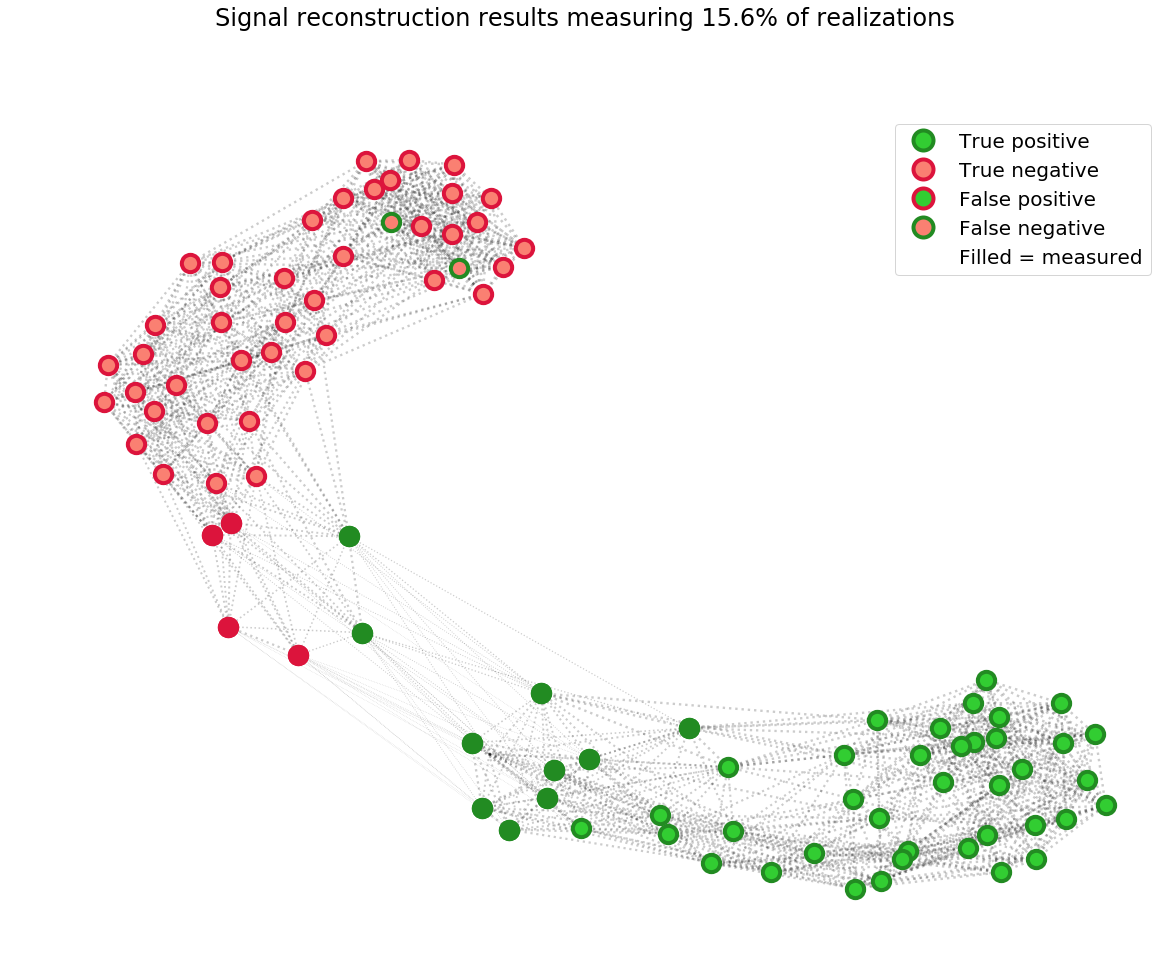

In [197]:
def show_prediction(index, sen):
    ''' select a vote and predict its outcome using transductive learning and the swing senators votes '''
    labels_bin = get_thresholded_values(votes_test.values[:,index], threshold=0)
    print_info_short(votes_test.columns[index])
    
    print(labels_bin)
    
    mask = np.zeros(votes_test.shape[0])
    mask[sen] = 1
    
    sol, sol_bin =  reconstruct_signal(G_pred,mask,labels_bin)
    plot_prediction(G_pred, sol_bin, labels_bin, mask)

    print("Error binarized: " + str(error(labels_bin, sol_bin)))
    print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
    
show_prediction(1, swing_senators)

============== INFORMATION REGARDING pn30-115-58-1 ============== 


[-1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  0. -1. -1. -1. -1.  1.
 -1. -1.  0. -1.  0.  1.  1.  1. -1.  1. -1. -1.  0. -1. -1. -1. -1.  1.
 -1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.
 -1. -1. -1.  0.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.
 -1.  1.  1.  0.  1. -1.]
Error binarized: 0.21081851067789195
Accuracy binarized: 0.9583333333333334


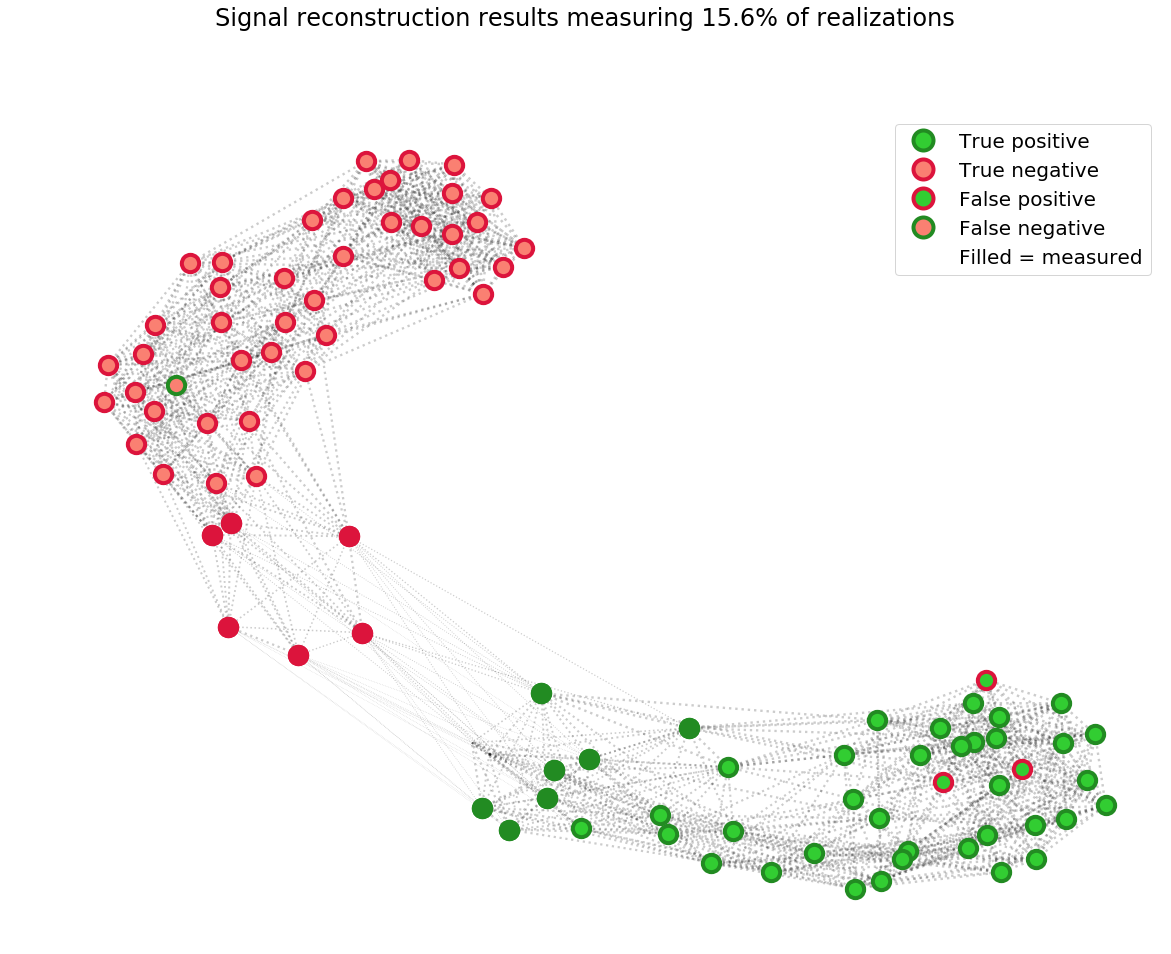

In [198]:
show_prediction(9, swing_senators)

How does this compare to the same number of measures, but taken at random ? 

In [199]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
a = predict_and_compare(G_pred, votes_test, random_senators)

                         name party
member_id                          
K000384             Tim Kaine     D
C001070             Bob Casey     D
B000944         Sherrod Brown     D
F000463           Deb Fischer     R
M001170      Claire McCaskill     D
L000577              Mike Lee     R
T000464            Jon Tester     D
W000802    Sheldon Whitehouse     D
B001236          John Boozman     R
M001183           Joe Manchin     D
R000584             Jim Risch     R
F000062      Dianne Feinstein     D
Y000064            Todd Young     R
W000817      Elizabeth Warren     D
H001075         Kamala Harris     D
True: {-1: 10, 1: 86} Pred: {-1: 1, 1: 95} Correct: True
True: {-1: 45, 0: 1, 1: 50} Pred: {-1: 49, 0: 1, 1: 46} Correct: False
True: {-1: 46, 0: 1, 1: 49} Pred: {-1: 46, 0: 1, 1: 49} Correct: True
True: {-1: 11, 0: 2, 1: 83} Pred: {-1: 1, 1: 95} Correct: True
True: {-1: 49, 1: 47} Pred: {-1: 48, 1: 48} Correct: True
True: {-1: 2, 1: 94} Pred: {-1: 1, 1: 95} Correct: True
True: {-1: 5,

============== INFORMATION REGARDING sconres3-115-10-1 ============== 
Bill title: A concurrent resolution setting forth the congressional budget for the United States Government for fiscal year 2017 and setting forth the appropriate budgetary levels for fiscal years 2018 through 2026.

Bill url:  https://www.govtrack.us/congress/bills/115/sconres3


[-1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  0. -1. -1. -1. -1.  1.
 -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.
 -1.  1.  1.  1.  1. -1.]
Error binarized: 0.41039134083406165
Accuracy binarized: 0.9583333333333334


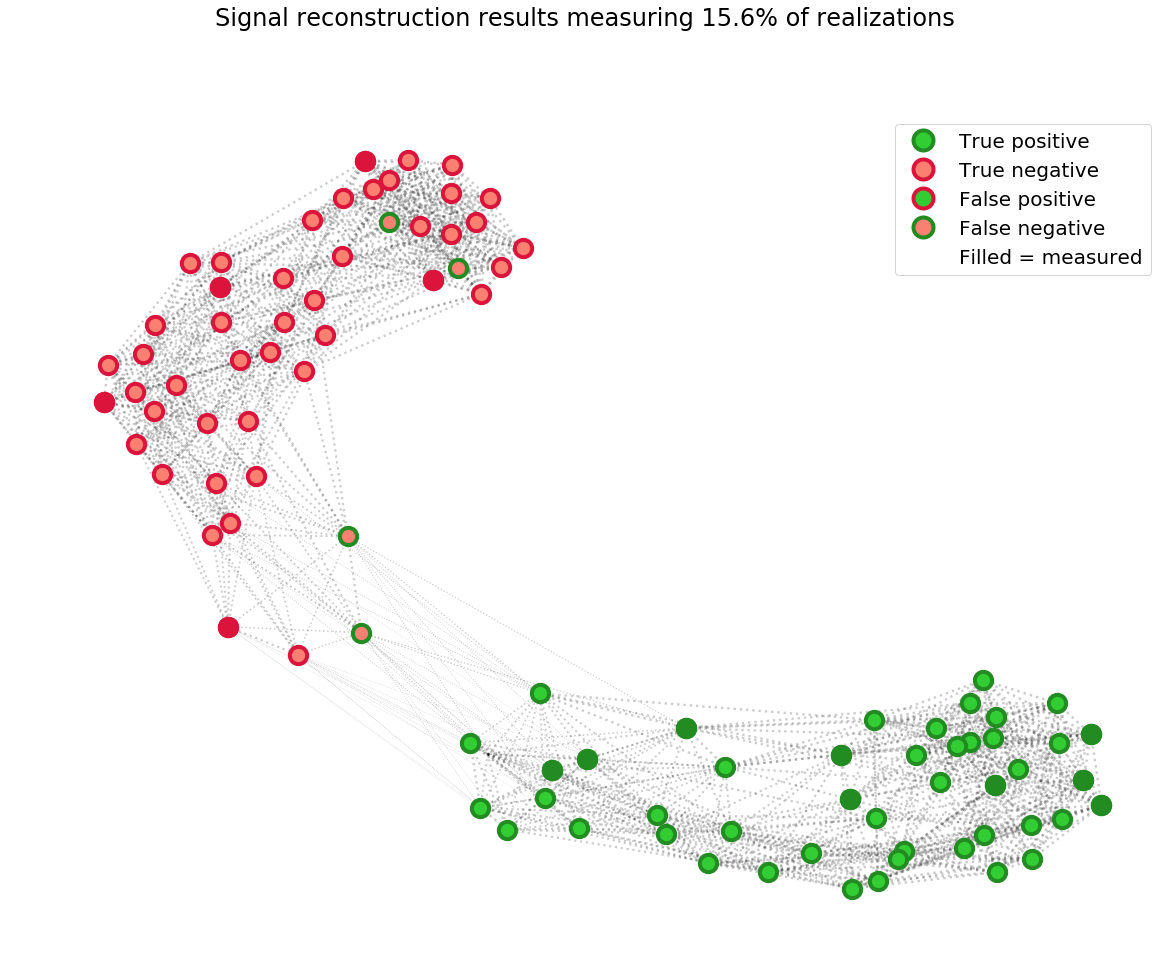

In [200]:
show_prediction(1, random_senators)

============== INFORMATION REGARDING pn30-115-58-1 ============== 


[-1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  0. -1. -1. -1. -1.  1.
 -1. -1.  0. -1.  0.  1.  1.  1. -1.  1. -1. -1.  0. -1. -1. -1. -1.  1.
 -1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.
 -1. -1. -1.  0.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.
 -1.  1.  1.  0.  1. -1.]
Error binarized: 0.23570226039551584
Accuracy binarized: 0.9479166666666666


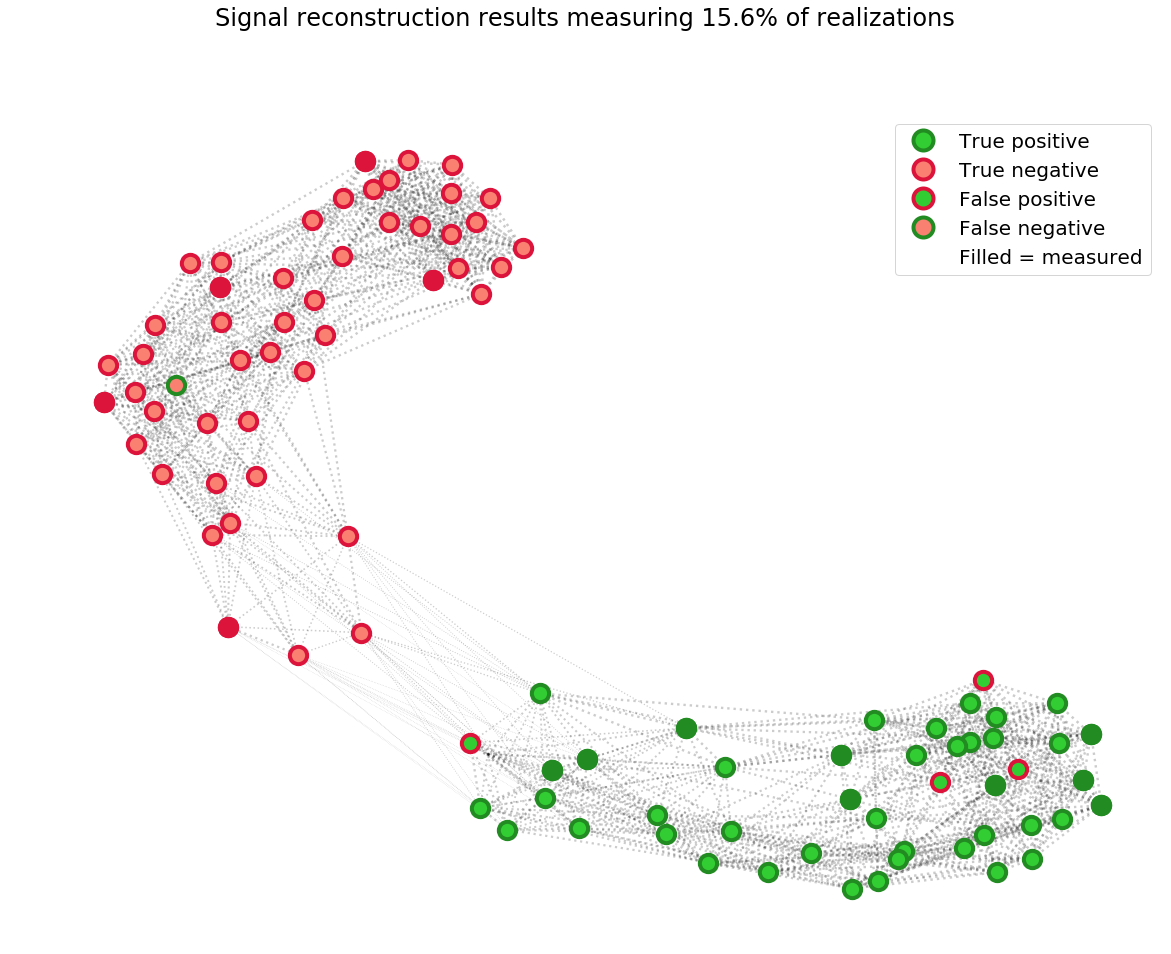

In [201]:
show_prediction(9, random_senators)